# Set-Up

In [1]:
!pip install easyocr

In [2]:
!pip install sentencepiece

In [3]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [4]:
!sudo apt install tesseract-ocr-rus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-rus is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [5]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
!pip install accelerate -U

In [7]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-s9rpw785
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-s9rpw785
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done


In [8]:
!pip install -q datasets seqeval

In [9]:
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image, ImageDraw
import json
import os
import datasets
import easyocr
import PIL
from PIL import ImageDraw
from pdf2image import convert_from_path

# Just replace tesseract with easyocr, bro

In [12]:
label_list = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(label_list)}
label2id = {k: v for v, k in enumerate(label_list)}

In [13]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_checkpoint",
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         num_labels=len(label_list))

In [14]:
from transformers import LayoutXLMProcessor

# I can actually choose language for tess ocr
processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=True, ocr_lang='rus')

preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.4.13.0.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

In [15]:
# cool

processor.image_processor

LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv2FeatureExtractor",
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": "rus",
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

In [16]:
processor.tokenizer

LayoutXLMTokenizerFast(name_or_path='microsoft/layoutxlm-base', vocab_size=250002, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [101]:
easy_ocr_reader = easyocr.Reader(['ru'])

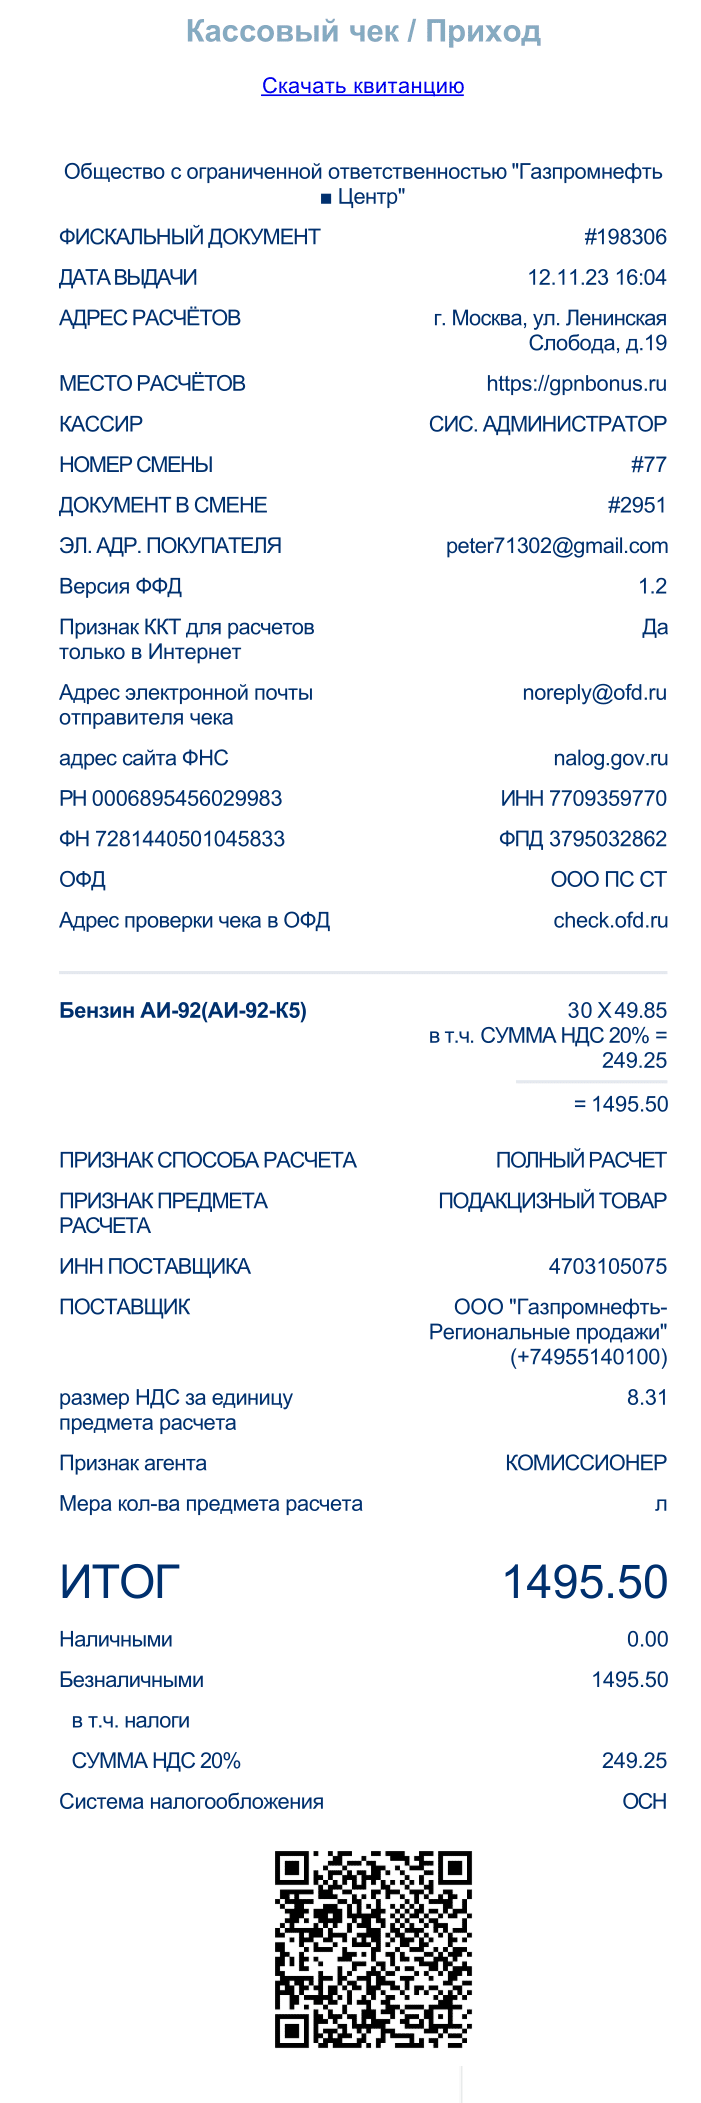

In [18]:
image_path = Path('/content/drive/MyDrive/receipt_dataset/test/peter_6.png')
pil_image = PIL.Image.open(image_path)
pil_image

In [19]:
bounds = easy_ocr_reader.readtext(np.asarray(pil_image), width_ths=0.1, y_ths=0.1)

In [20]:
# output is 3-element tuple, the list of [x1, y1, x2, y2]
# detected text
# confident score

bounds[4]

([[350, 76], [466, 76], [466, 96], [350, 96]], 'квитанцию', 0.958590789521001)

In [21]:
def draw_boxes(image, bounds, color='yellow', width=2):
  draw = ImageDraw.Draw(image)
  for bound in bounds:
    points = bound[0]
    x0, y0 = points[0]
    x1, y1 = points[2]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=width)

  return image

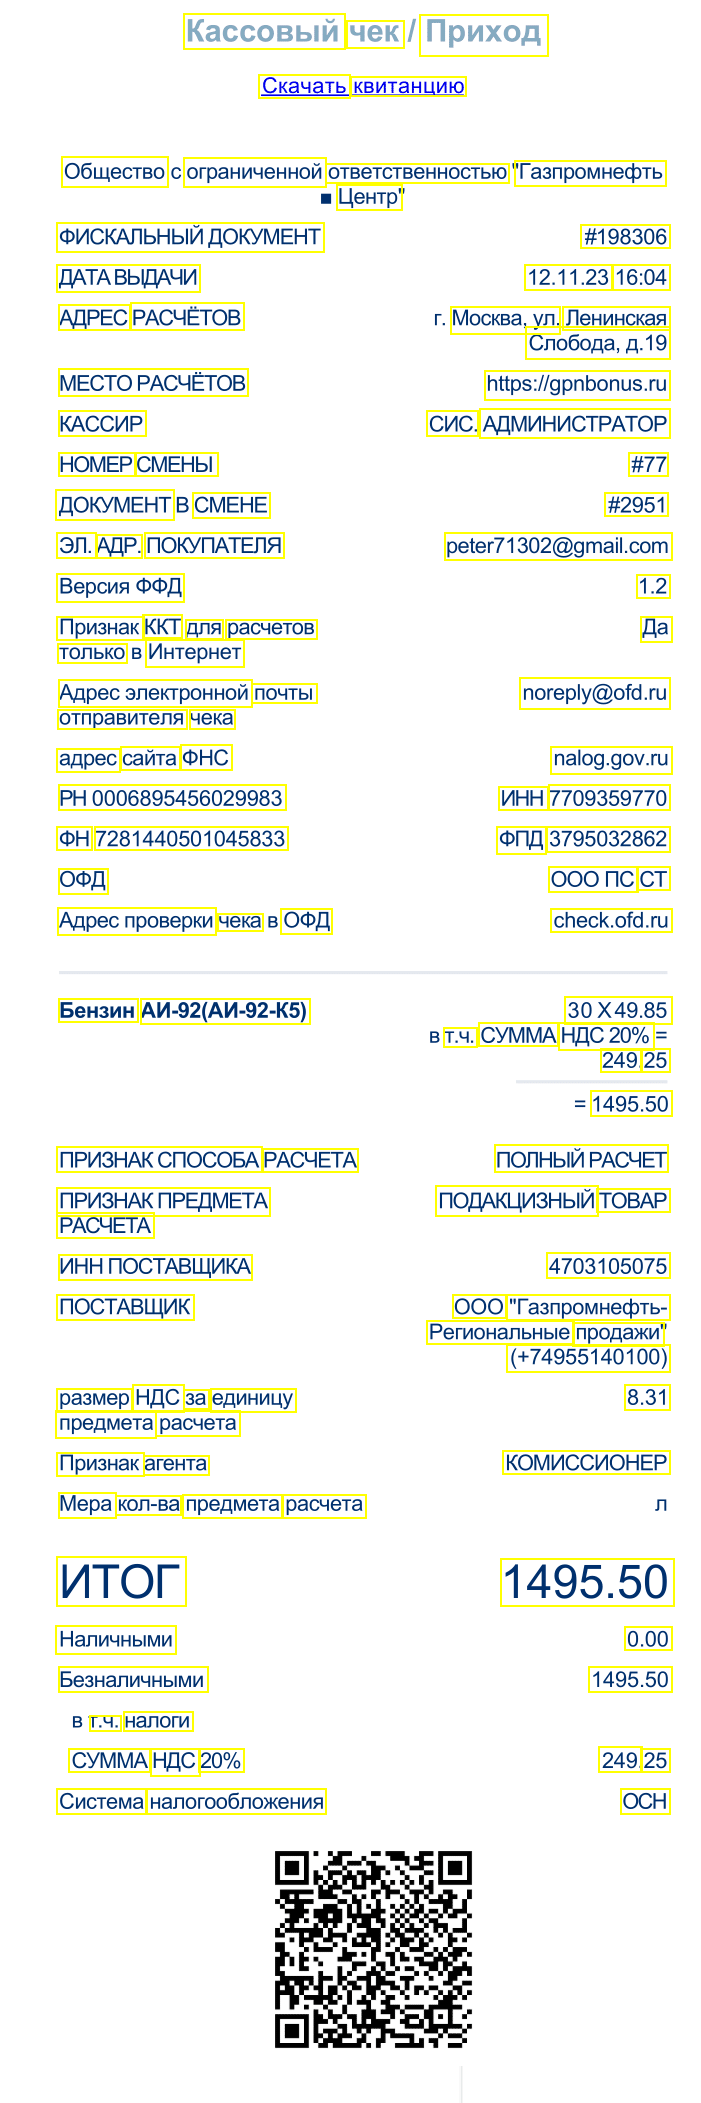

In [22]:
# тут неплохо, но некоторые примеры мне вообще не нравятся

draw_boxes(pil_image, bounds)

In [23]:
def draw_by_path(image_path, reader):

  pil_image = PIL.Image.open(image_path)
  bounds = reader.readtext(np.asarray(pil_image), width_ths=0.1, y_ths=0.1)

  return draw_boxes(pil_image, bounds)

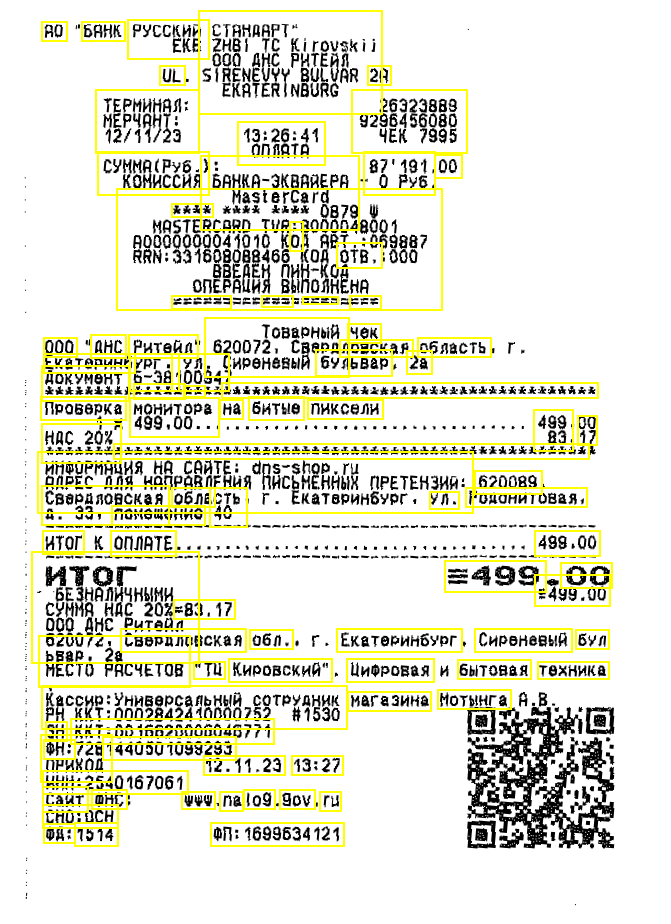

In [94]:
# например peter_2/ вот бы как-то научить детектить это построчно.
# возможно это происходит из-за относительно низкого качества скана?
# на других примерах вроде норм

image_path = Path('/content/drive/MyDrive/receipt_dataset/test/peter_2.png')
draw_by_path(image_path, easy_ocr_reader)

In [99]:
test_im = convert_from_path('/content/drive/MyDrive/receipt_dataset/cool_example.pdf')[0]
easy_ocr_reader = easyocr.Reader(['ru'])

bounds = easy_ocr_reader.readtext(np.asarray(test_im), width_ths=0.1, y_ths=0.1)

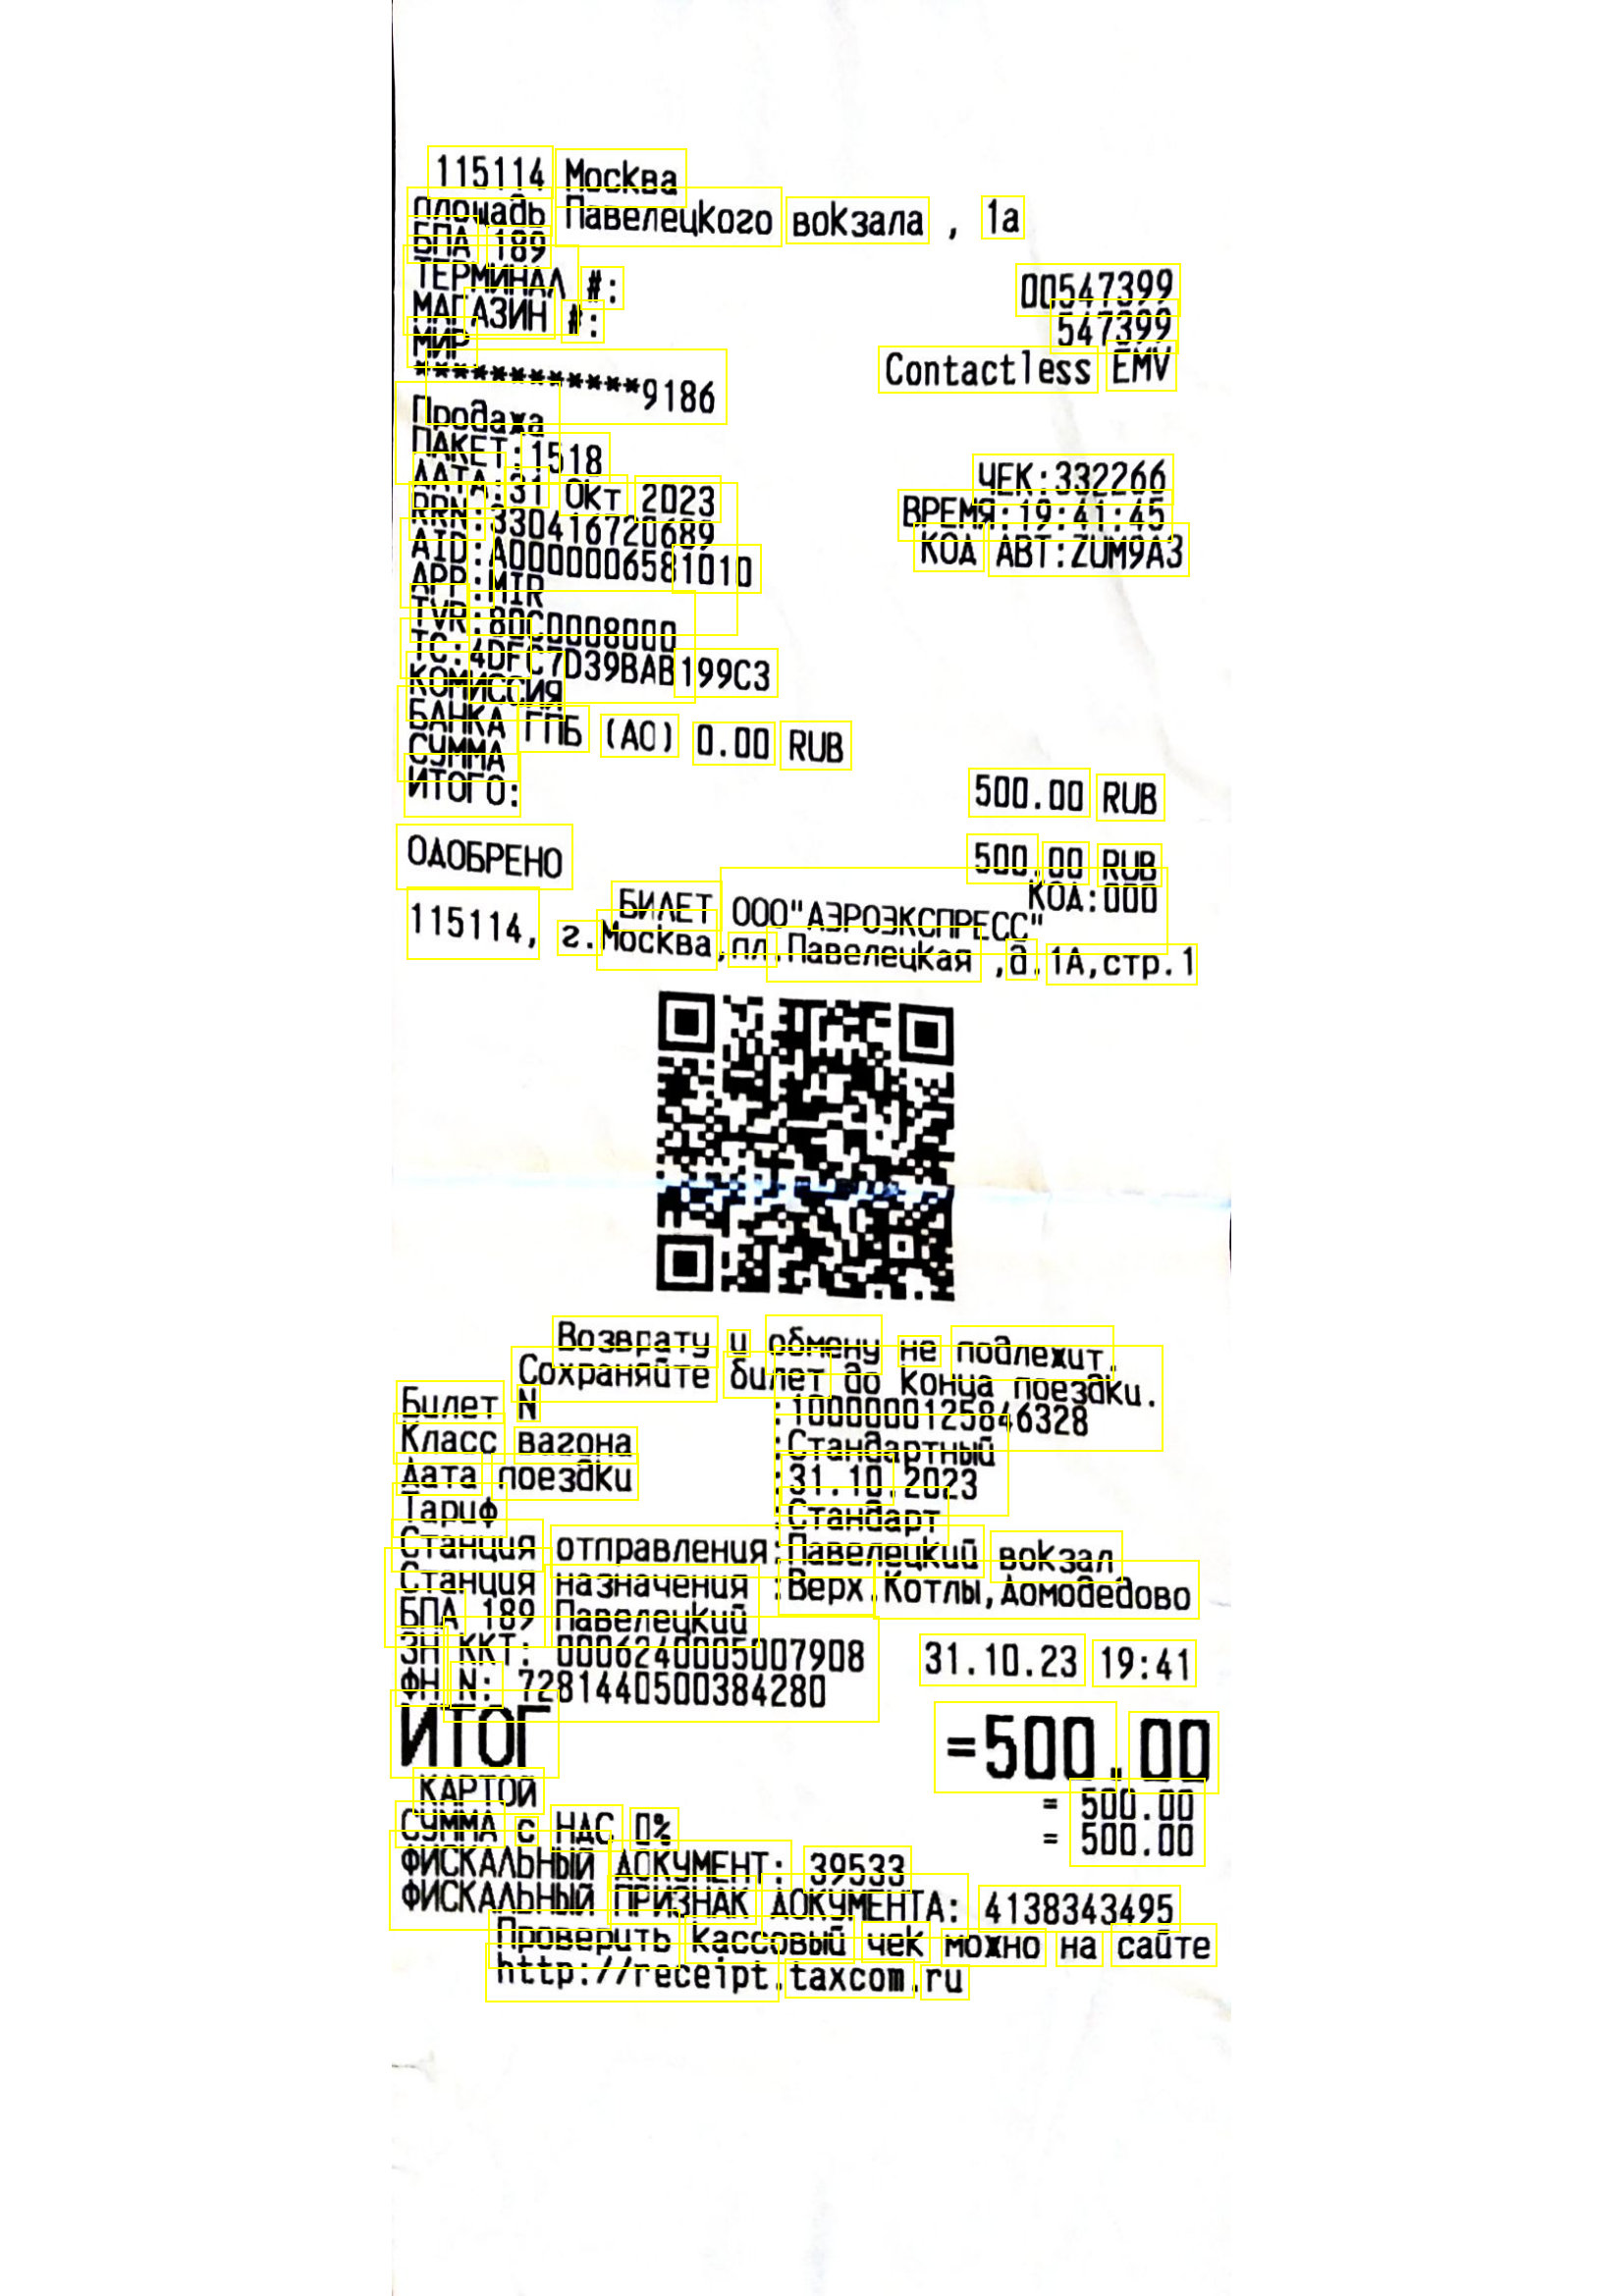

In [102]:
test_im_copy = test_im.copy()
draw_boxes(test_im_copy, bounds)

In [107]:
for r in bounds:
  print(f'word: {r[1]}\t\t score: {r[2]}')

word: 115114		 score: 1.0
word: Москва		 score: 0.6924010880212322
word: рдоцабь		 score: 0.46982359196960366
word: Павелецко2о		 score: 0.8599309055861146
word: воКзала		 score: 0.4854591304877123
word: 1а		 score: 0.9814652203856578
word: БПЫ		 score: 0.703842272990793
word: 189		 score: 0.9999986923153217
word: ЙЁАзин		 score: 0.4288676209409348
word: #;		 score: 0.7548409094196281
word: [0547399		 score: 0.9375631183065284
word: АЗИН		 score: 0.999901533126831
word: #:		 score: 0.9891149709887214
word: 547399		 score: 0.9986761095542535
word: МИР'		 score: 0.3691806197166443
word: [пжаж #**ж*ж9186		 score: 0.2164542609710724
word: (оп-а--] ::		 score: 0.09487211057212379
word: ЕМ		 score: 0.7044767095023418
word: [пата		 score: 0.14831950353582496
word: 1518		 score: 0.9999769330024719
word: 31		 score: 0.9999957853177504
word: ОКт		 score: 0.9938837857070928
word: 2023		 score: 0.8379999399185181
word: ЧЕК:332266		 score: 0.9956588803928522
word: ВРЕМЯ: 19:41:45		 score: 0.8484976

# Some Bright Idea

In [25]:
# hmm what if I just use easy_ocr results and pass them into layoutxlm processor
# with apply_ocr=False and then just pass encodings to the model

from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

In [26]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_rus_trained")

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device);

In [28]:
def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]

In [60]:
image_path = Path('/content/drive/MyDrive/receipt_dataset/test/peter_6.png')
ex_image = PIL.Image.open(image_path)
w, h = ex_image.size
h, w

(2103, 701)

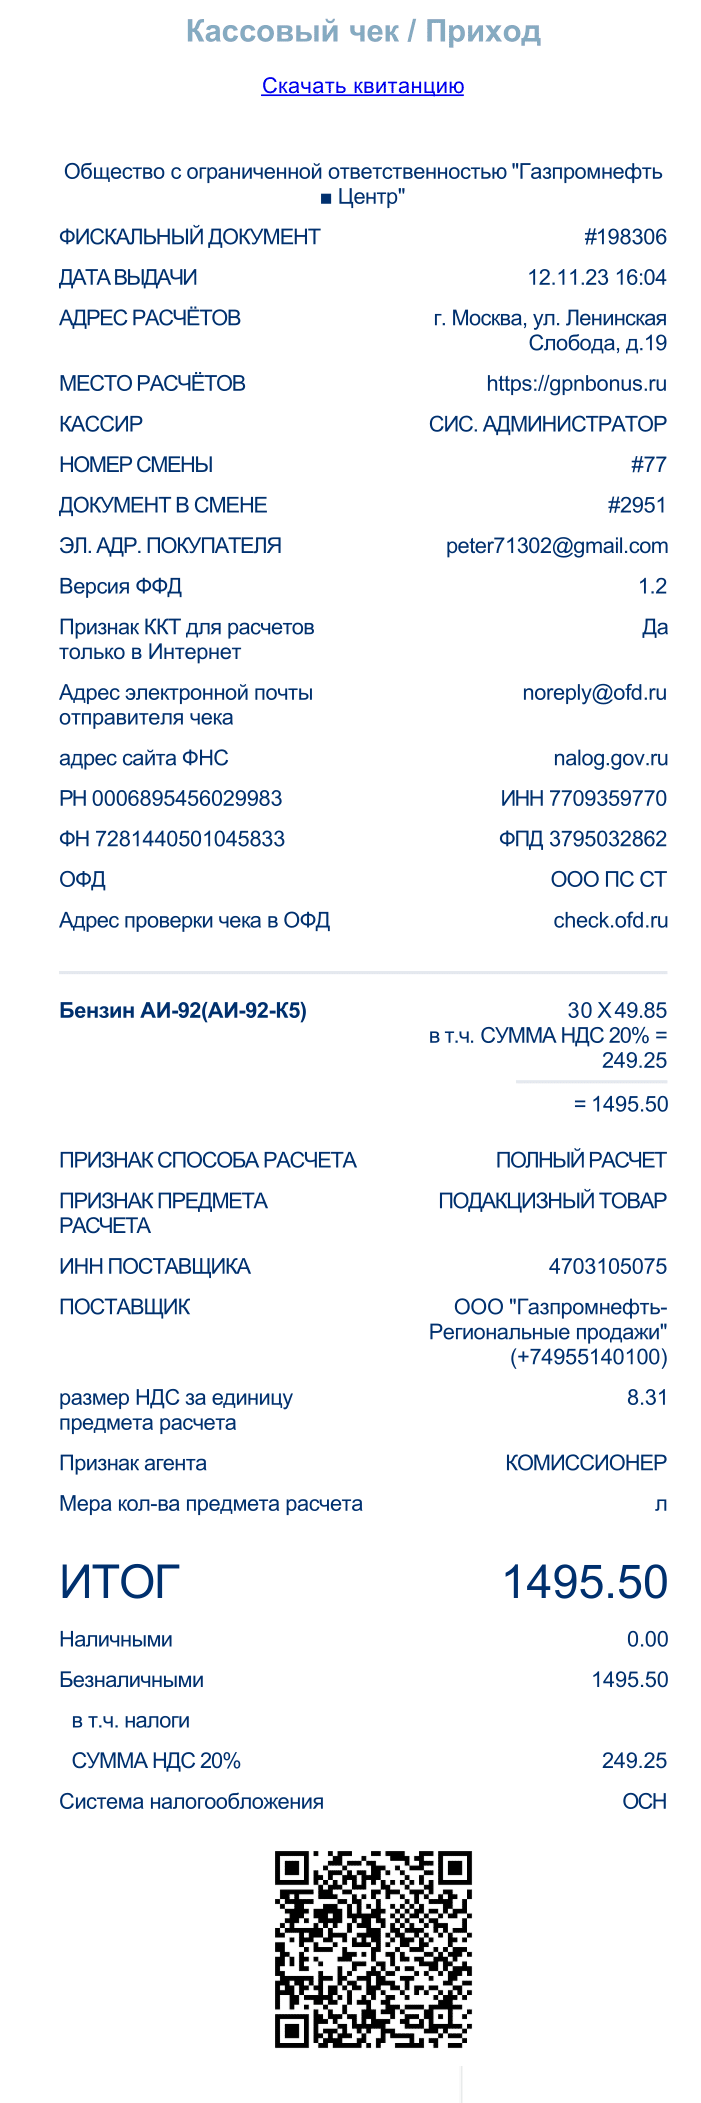

In [61]:
ex_image

In [62]:
ocr_results = easy_ocr_reader.readtext(np.asarray(ex_image), width_ths=0.1, y_ths=0.1)
ocr_results[0]

([[183, 13], [345, 13], [345, 49], [183, 49]], 'Кассовый', 0.999996965425)

In [63]:
formatted_results = []

for result in ocr_results:
  points = result[0]

  p0, p2 = points[0], points[2]
  x0, y0, x2, y2 = p0[0], p0[1], p2[0], p2[1]

  norm_box = normalize_box_1000([x0, y0, x2, y2], h, w)
  formatted_results.append((norm_box, result[1]))

In [64]:
formatted_results[:5]

[([261, 6, 492, 23], 'Кассовый'),
 ([493, 9, 576, 22], 'чек'),
 ([597, 6, 781, 26], 'Приход'),
 ([368, 35, 499, 46], 'Скачать_'),
 ([499, 36, 664, 45], 'квитанцию')]

In [65]:
words = [res[1] for res in formatted_results]
boxes = [res[0] for res in formatted_results]

words[0], boxes[0]

('Кассовый', [261, 6, 492, 23])

In [72]:
encoding = processor(ex_image, text=words, boxes=boxes, truncation=True,
                     return_offsets_mapping=True, return_tensors="pt",
                     padding="max_length", max_length=512)

offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'image'])


In [67]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

In [68]:
outputs = model(**encoding)
print(outputs.logits.shape)

torch.Size([1, 512, 9])


In [73]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = ex_image.size

In [74]:
# will make sure that boxes aren't fucked up

def unnormalize_1000_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000)),
     ]

In [75]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

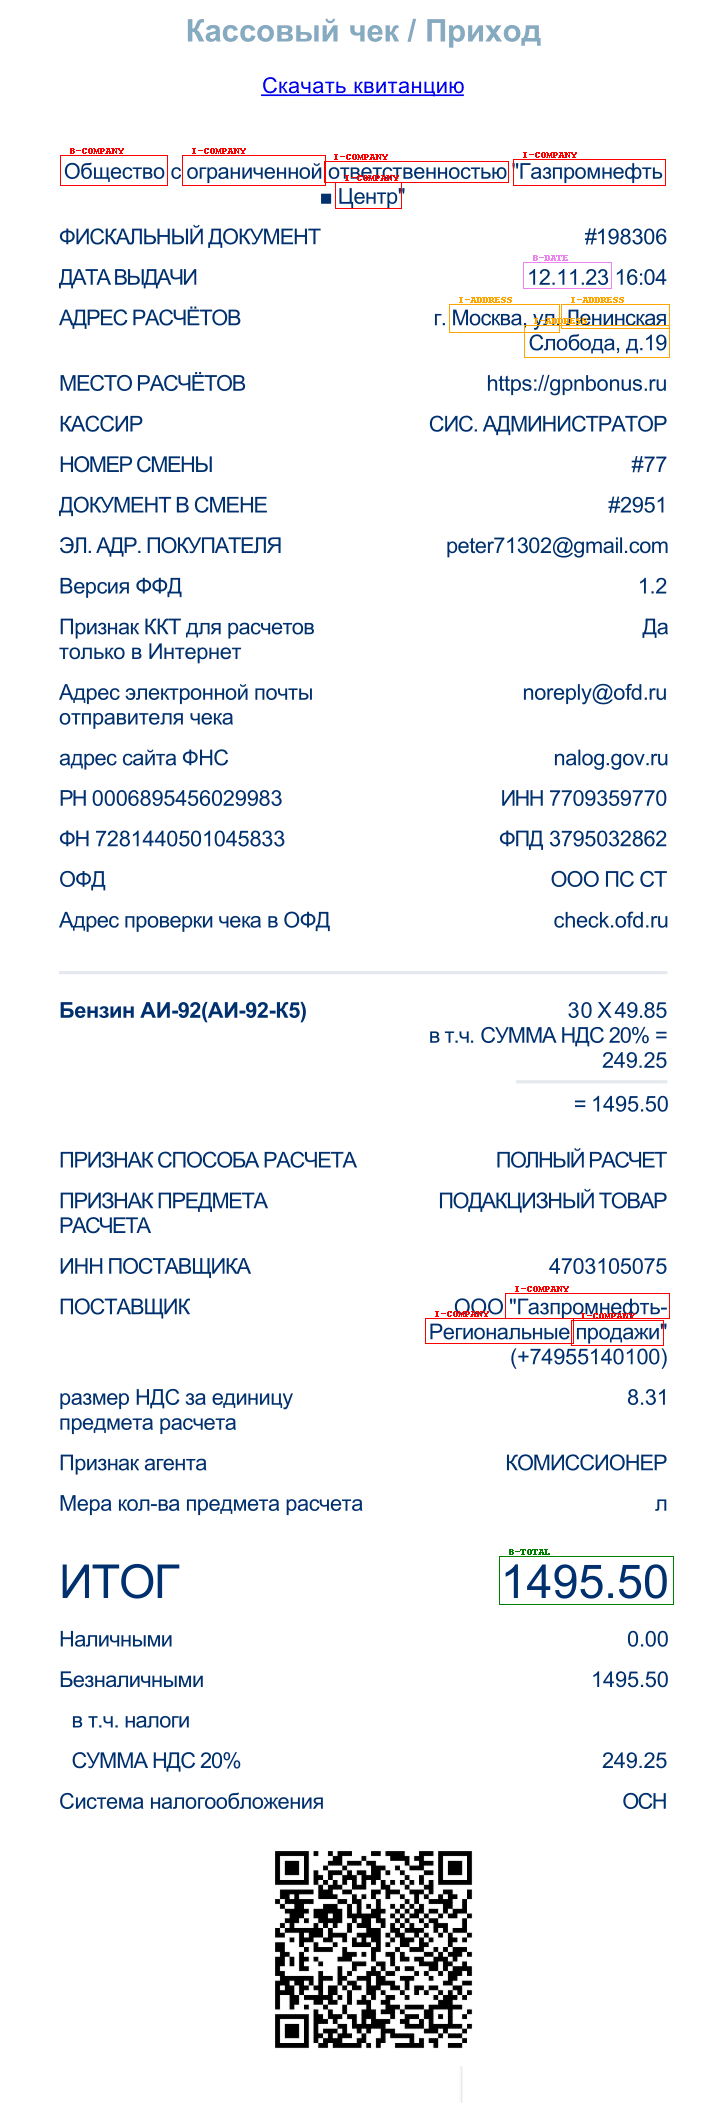

In [76]:
ex_image_copy = ex_image.copy()
draw = ImageDraw.Draw(ex_image_copy)

def iob_to_label(label):
    if not label:
      return 'O'
    return label

label2color = {'O':'gray', 'B-COMPANY':'red', 'I-COMPANY':'red', 'B-ADDRESS': 'orange',
               'I-ADDRESS': 'orange', 'B-DATE':'violet', 'I-DATE':'violet', 'B-TOTAL':'green', 'I-TOTAL':'green'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    if predicted_label != 'O':
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

ex_image_copy

In [77]:
def get_informative_tokens_text(encoding, offset_mapping, outputs, id2label, processor):

  input_ids = encoding['input_ids'].squeeze().tolist()

  is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

  predictions = outputs.logits.argmax(-1).squeeze().tolist()
  true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]

  full_words = []
  word_idx = []
  for i in range(len(is_subword) - 1):
    word_idx.append(i)
    if is_subword[i + 1]:
      continue
    else:
      full_words.append(''.join([processor.tokenizer.decode(input_ids[id]) for id in word_idx]))
      word_idx = []
  # adding 'end' token
  full_words.append('</s>')

  inf_pred_word_tuples = []
  for i in range(len(true_predictions)):
    if true_predictions[i] != id2label[0]:
       inf_pred_word_tuples.append((true_predictions[i], full_words[i]))

  return inf_pred_word_tuples

In [78]:
get_informative_tokens_text(encoding, offset_mapping, outputs, id2label, processor)

[('B-COMPANY', 'Общество'),
 ('I-COMPANY', 'ограниченной'),
 ('I-COMPANY', 'ответственностью'),
 ('I-COMPANY', "'Газпромнефть"),
 ('I-COMPANY', "Центр'"),
 ('B-DATE', '12.11.23'),
 ('I-ADDRESS', 'Москва;ул:'),
 ('I-ADDRESS', 'Ленинская'),
 ('I-ADDRESS', ''),
 ('I-ADDRESS', 'Слобода,д.19'),
 ('I-COMPANY', '"Газпромнефть-'),
 ('I-COMPANY', 'Региональные'),
 ('I-COMPANY', "продажи'"),
 ('B-TOTAL', '1495.50')]